In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import product

In [2]:
from commons import smoothen

In [3]:
fontsize = 14

# Loading the data

## Raw data

Our Scan-O-matic data comes in the form of a NumPy array named `curves_raw.npy`, which we load here. Additionally, we smoothen it with an window of 5 :

In [4]:
Nt = smoothen(np.load("curves_raw.npy"), 5)

For convenience, we also get the dimensions of this array :

In [5]:
n_plates, n_rows, n_columns, n_points = Nt.shape
plates, rows, columns, points = map(np.arange, Nt.shape)

## Derivatives

We compute the discrete derivatives $\frac{\Delta N_i(t)}{\Delta t} = \Delta N_i(t) = N_i(t+1) - N_i(t)$

In [6]:
dNdt = np.full_like(Nt, np.nan)
dNdt[..., :-1] = Nt[..., 1:] - Nt[..., :-1]

and $\rho_i(t) = \frac{\Delta N_i(t)}{N_i(t)}$

In [7]:
rho = np.full_like(Nt, np.nan)
rho[..., :-1] = dNdt[..., :-1] / ((Nt[..., 1:] + Nt[..., :-1]) / 2)

## Growth phases

We start by calculating the time taken until maximum growth $t_{\rho_{max}}$ :

In [8]:
_Nt = Nt.reshape((n_plates, -1, n_points)).mean(axis = 1)
_rho = rho[..., :-1].reshape((n_plates, -1, n_points-1)).mean(axis = 1)

In [9]:
t_max = _rho.argmax(axis = -1)

We then obtain for every environment the time until median growth is reached, with a cut-off to $\rho_{t_{max}}$ :

In [10]:
t_exp = [ (_rho[p] >= np.median(_rho[p, :t_max[p]+1])).argmax() - 1 for p in plates ]

We repeat this but once $\rho_{t_{max}}$ has been reached :

In [11]:
t_decel = [ (_rho[p, t_max[p]:] >= np.median(_rho[p, t_max[p]+1:])).argmin() + t_max[p] for p in plates ]

That way, we have the times subdividing adjustment, exponential and deceleration phases of growth.

# Figure

## All in one

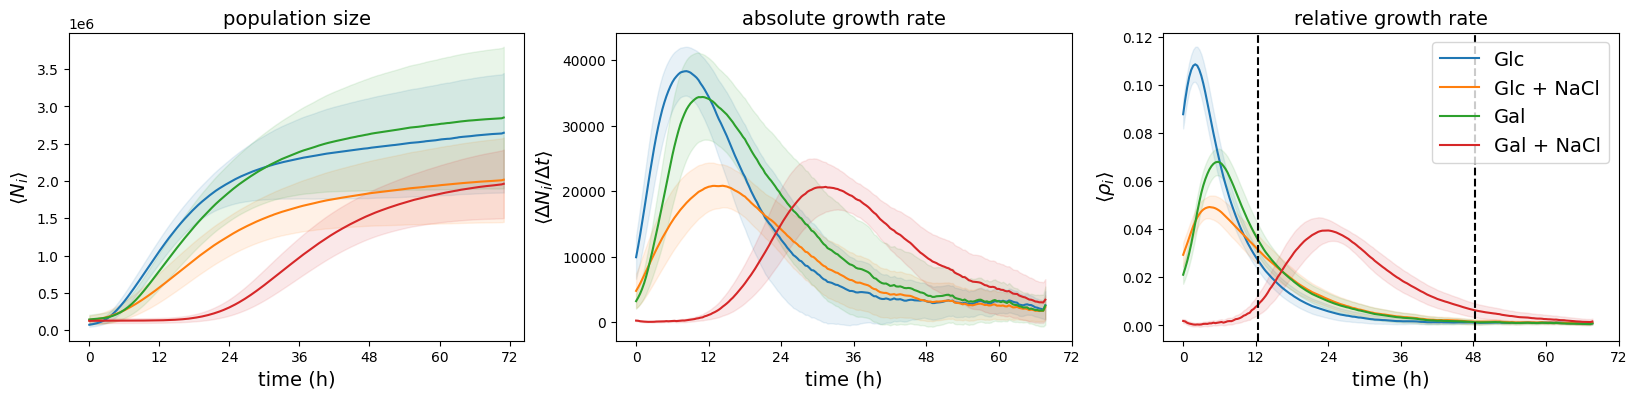

In [12]:
fig, (ax_N, ax_dNdt, ax_dNN) = plt.subplots(ncols = 3, figsize = (20, 4))
indexes = (1, 2, 3, 0)
names = ("Glc", "Glc + NaCl", "Gal", "Gal + NaCl")
cs = ("tab:blue", "tab:orange", "tab:green", "tab:red")

for p, color in zip(indexes, cs):
    nt = Nt[p].reshape((n_rows * n_columns, -1))
    m, std = nt.mean(axis = 0), nt.std(axis = 0)
    ax_N.plot(m, color = color)
    ax_N.fill_between(points[:m.shape[0]], m - std, m + std, color = color, alpha = 0.1)
ax_N.set_title("population size", fontsize = fontsize)
ax_N.set_xlabel("time (h)", fontsize = fontsize)
ax_N.set_ylabel(r"$\langle N_i\rangle$", fontsize = fontsize)
ax_N.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])

for p, color in zip(indexes, cs):
    dndt = smoothen(dNdt[p], 10).reshape((n_rows * n_columns, -1))
    m, std = dndt.mean(axis = 0), dndt.std(axis = 0)
    ax_dNdt.plot(m, color = color)
    ax_dNdt.fill_between(points[:m.shape[0]], m - std, m + std, color = color, alpha = 0.1)
ax_dNdt.set_title("absolute growth rate", fontsize = fontsize)
ax_dNdt.set_xlabel("time (h)", fontsize = fontsize)
ax_dNdt.set_ylabel(r"$\langle\Delta N_i / \Delta t\rangle$", fontsize = fontsize)
ax_dNdt.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])

for p, name, color in zip(indexes, names, cs):
    dnn = smoothen(rho[p], 10).reshape((n_rows * n_columns, -1))
    m, std = dnn.mean(axis = 0), dnn.std(axis = 0)
    ax_dNN.plot(m, label = name, color = color)
    ax_dNN.fill_between(points[:m.shape[0]], m - std, m + std, color = color, alpha = 0.1)
ax_dNN.axvline(t_exp[0], color = "black", linestyle = "--")
ax_dNN.axvline(t_decel[0], color = "black", linestyle = "--")
ax_dNN.set_title("relative growth rate", fontsize = fontsize)
ax_dNN.set_xlabel("time (h)", fontsize = fontsize)
ax_dNN.set_ylabel(r"$\langle\rho_i\rangle$", fontsize = fontsize)
ax_dNN.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])

l = ax_dNN.legend(loc = "upper right",fontsize = fontsize)

fig.savefig("plots/figure-1/time-series_N-dNdt-dNN.pdf", bbox_inches = "tight")
fig.savefig("plots/figure-1/time-series_N-dNdt-dNN.png", bbox_inches = "tight");